# Ramdomized Selection and Deterministic Selection

## 1. 서론
본 보고서에서는 서로 다르게 구현된 k-th smallest selection algorithm의 비교를 목적으로 한다. 

Randomized Selction 알고리즘은 average-case $\Theta(n)$의 시간복잡도를 가진다. 그러나 worst-case에서 $\Theta(n^2)$의 시간이 걸린다. 따라서 파티션의 피봇이 가장 작은 원소 혹은 가장 큰 원소로 연속적으로 설정되면, 수행 시간의 손실이 크다.

Deterministic Selection 알고리즘은 radomized Selction 알고리즘보다 상수 overhead가 크지만, worst-case에서 $\Theta(n)$의 시간복잡도를 가진다. 즉, randomzied selection보다 일반적으로 조금 느려지는 대신 worst-case에서는 보다 빠른 속도를 보장한다. 본 보고서에서는 이러한 균형을 달성하기 위해 증가하는 overhead가 어느 정도인지 측정해보고자 한다.


이를 위하여 두 알고리즘을 수행하고 확인하는 프로그램을 python으로 구현하였다. 구현과 실행에 사용한 환경은 python 3.8.6rc1이고, 다음과 같은 command line으로 실행한다. 다음은 1M 크기의 input에 대한 sample running이다.

In [1]:
!python main.py

i-th smallest number by randomized selection:  218395
Execution time by randomized selection:  83
Check randomized selection: True
i-th smallest number by deterministic selection:  218395
Execution time by deterministic selection:  1367
Check deterministic selection: True


구현을 위해 사용한 내장 패키지들은 다음과 같다. 수행 시간 측정을 위해 time을, 각 알고리즘 실행 시 call by reference로 인한 데이터의 변경을 막기 위해 copy를, deterministic selection 시 그룹의 개수를 계산하기 위해 math를 import하였다.

In [ ]:
import time
import copy
import math

## 2. 알고리즘의 구현

### 2.1 Randomized Selection
Randomized Selction 알고리즘을 다음과 같이 구현하였다. RandomizedSelect 함수는 input으로 list의 길이와, 그 list, 그리고 i를 받아 그 list에서 i번째로 작은 수를 반환한다.

In [ ]:
def randomizedSelect(length, numList, i):
    startTime = time.time()
    
    output = select(numList,0,length-1,i)

    # execution time in ms
    executedTime = int((time.time()-startTime) * 1000)

    # save result to deter.txt
    with open("random.txt", "w") as f:
        f.write(str(output)+'\n')
        f.write(str(executedTime)+"ms")

    return output, executedTime

def select(numList, p, r, i):
    # if length of list is 1, return the only element
    if p == r:
        return numList[p]

    # else, make partition and return index of pivot
    q = partition(numList, p, r)

    # pivot is the k-th smallest
    k = q-p+1

    if i < k:
        return select(numList, p, q-1, i)
    elif i == k:
        return numList[q]
    else:
        return select(numList, q+1, r, i-k)

Ramdomzied Selction의 partition 알고리즘은 해당 리스트의 마지막 원소를 피봇으로 설정한다. 따라서 피봇이 임의의 rank의 원소로 설정된다. 이러한 측면에서 이 알고리즘이 randomzied Selction 이라고 명명된다. 그러나 만약 partition 시 피봇의 rank가 최소나 최대에 가까우면, 알고리즘의 성능이 매우 떨어지게 되는 단점이 있다.

In [ ]:
def partition(numList, p, r):
    # use last element as pivot
    pivot = numList[r]
    i = p-1
    for j in range(p, r):
        if numList[j] <= pivot:
            i += 1
            numList[i], numList[j] = numList[j], numList[i]
    numList[i+1], numList[r] = numList[r], numList[i+1]
    return i+1

### 2.2. Deterministic Selection
Deterministic Selction 알고리즘을 다음과 같이 구현하였다. deterministicSelect 함수는 input으로 list의 길이와, 그 list, 그리고 i를 받아 그 list에서 i번째로 작은 수를 반환한다.

In [ ]:
def deterministicSelect(length, numList, i):
    startTime = time.time()
    
    output = linearSelect(numList,0,length-1,i)

    # execution time in ms
    executedTime = int((time.time()-startTime) * 1000)

    # save result to random.txt
    with open("deter.txt", "w") as f:
        f.write(str(output)+'\n')
        f.write(str(executedTime)+"ms")

    return output, executedTime

def linearSelect(numList, p, r, i):
    # if length of list is 1, return the only element
    if p == r:
            return numList[p]
    # else if length <=5, insertion sort the list and return i-th smallest
    elif r-p+1 <= 5:
        numList = insertionSort(numList, p, r)
        return numList[p+i-1]
    # else choose not extreme pivot by recursive call
    else:
        numGroups = math.ceil((r-p+1)/5)
        lengthLastGroup = (r-p+1) % 5
        medians = list()

        # group each 5 elements and get median
        for j in range(p, r+1, 5):
            # if last group is not full, median index is different
            if r-j < 4:
                numList = insertionSort(numList, j, j+lengthLastGroup-1)
                medians.append(numList[j + (lengthLastGroup-1)//2])
            else:
                numList = insertionSort(numList, j, j+4)
                medians.append(numList[j+2])
        
        # choose median of medians as pivot recursively
        pivot = linearSelect(medians, 0, numGroups-1, numGroups//2)

        # partition with the pivot and return index of pivot
        q = partitionWithPivot(numList, p, r, pivot)

        # pivot is the k-th smallest
        k = q-p+1

        if i < k:
            return linearSelect(numList, p, q-1, i)
        elif i == k:
            return numList[q]
        else:
            return linearSelect(numList, q+1, r, i-k)

Deterministic selection의 partition 알고리즘은 임의의 인덱스로 피봇을 설정하는 대신, 중간값에 가까운 피봇 값을 받아 partition을 수행한다. partition은 피봇이 중간값에 가깝게 설정될수록 그 효율이 높으므로, 알고리즘이 극단적인 피봇의 선택에 robust하다. 그러나 중간값에 가까운 피봇을 찾는 과정에서 상수 오버헤드가 발생한다.

In [ ]:
def partitionWithPivot(numList, p, r, pivot):
    # find index of pivot by traveling once
    pivotIdx = findIdx(numList, p, r, pivot)

    # swap pivot with last element and same as partition in deterministic one
    numList[r], numList[pivotIdx] = numList[pivotIdx], numList[r]
    
    i = p-1
    for j in range(p, r):
        if numList[j] <= pivot:
            i += 1
            numList[i], numList[j] = numList[j], numList[i]
    numList[i+1], numList[r] = numList[r], numList[i+1]
    return i+1

위 코드에서 추가적으로 사용한 함수의 구현은 다음과 같다.

In [ ]:
def findIdx(numList, p, r, pivot):
    for i in range(p, r+1):
        if numList[i] == pivot:
            return i

def insertionSort(numList, p, r):
    for i in range(p+1, r+1):
        for j in range(i-1, p-1, -1):
            if numList[j] > numList[j+1]:
                numList[j], numList[j+1] = numList[j+1], numList[j]
            else:
                break
    return numList

### 2.3. Checker Program
Checker Program은 각 알고리즘이 정상적으로 작동하는지 검사하는 프로그램이다.

만약 정수의 list가 주어져 있고 그 원소인 x가 주어져 있다고 하자. 그리고 list에서 x보다 작은 정수는 a개, x와 같은 크기의 정수는 b개라고 하자. 이 때 x는 a+1번째 작은 수이거나, a+2번째 작은 수이거나, ...,  a+b번째 작은 수라고 할 수 있다. 따라서 x가 list에서 i번째 작은 수라고 하면, i는 a보다 크고, a+b보다는 작거나 같아야한다.

아래 checker program은 input으로 list, i, 각 알고리즘의 output, 알고리즘의 종류를 받은 후 각 알고리즘이 정상적으로 작동하는지 여부를 True/False로 반환한다. 이 checker는 list를 1회 travel하면서 output보다 작은 수의 개수 countSmaller와, output과 같은 크기의 수의 개수 countTie를 저장한다. 그리고 countSmaller < i <= countSmaller + countTie를 만족하는지 판단하여 결론을 내린다.

Input list를 1회 travel 하므로, 이 cheker는 $\Theta(n)$의 시간복잡도를 가진다.

In [ ]:
def checker(numList, i, output, mode):
    # record the number of smaller and tie by traveling the list once
    countSmaller = 0
    countTie = 0
    for x in numList:
        if x < output:
            countSmaller += 1
        elif x == output:
            countTie += 1
    
    # the output is correct iff countSmaller < i <= countSmaller + countTie
    # True or False for each algorithm
    result = (i > countSmaller) and (i <= countSmaller + countTie)
    
    # save the result of checker together in result.txt
    if mode == "random":
        with open("result.txt", "w") as f:
            f.write(str(result)+'\n')
    else:
        with open("result.txt", "a") as f:
            f.write(str(result))
    
    return result

## 3. 알고리즘의 비교
Input은 프로그램 외부에서 다음 코드를 실행하여 생성하였다. n을 변경하여 input list의 크기에 따른 수행 시간을 비교하였다. 이 때 seed를 고정하여 재현가능하도록 하였다.

In [ ]:
import numpy as np

np.random.seed(0)
n = 1000000
arr = np.random.randint(1, n+1, n)
s = ""
for i in range(n):
    s = s + str(arr[i]) + " "
s.strip

with open("input.txt", "w") as f:
    f.write(str(n) + '\n')
    f.write(s + '\n')
    f.write(str(np.random.randint(1,n+1)))

Input을 프로그램 내부에서 읽을 때는 다음과 같은 함수를 사용하였다.

In [ ]:
def readInput():
    with open("input.txt", 'r') as f:
        lines = f.readlines()
        length = int(lines[0])
        numList = list(map(int, lines[1].split()))
        i = int(lines[2])
    return length, numList, i

main 함수는 다음과 같다. readInput 함수로 txt파일을 메모리로 load하고, randomizedSelect, deterministicSelect를 차례로 수행하고 각각 checker로 올바르게 작동하는지 print한다.

In [ ]:
def main():
    length, numList, i = readInput()
    
    output, time = randomizedSelect(length, copy.deepcopy(numList), i)
    print("i-th smallest number by randomized selection: ", output)
    print("Execution time by randomized selection: ", time)
    print("Check randomized selection:", checker(numList, i, output, "random"))

    output, time = deterministicSelect(length, copy.deepcopy(numList), i)
    print("i-th smallest number by deterministic selection: ", output)
    print("Execution time by deterministic selection: ", time)
    print("Check deterministic selection:", checker(numList, i, output, "deter"))

Input array의 크기를 100,000부터 1,000,000까지 100,000 씩 늘려가며 수행 시간을 기록하여 그린 그래프는 다음과 같다. 두 알고리즘 모두 시간이 선형으로 증가함을 알 수 있다.

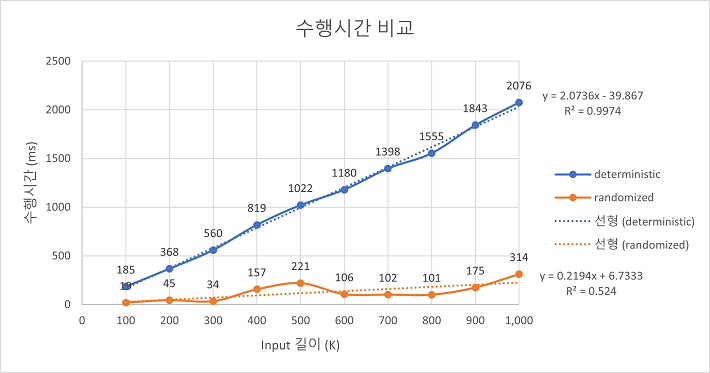

In [3]:
from IPython.display import Image
Image("figure.png")

이 때 추세선을 그려 두 그래프의 기울기를 비교하였다. 두 그래프의 기울기의 비는 $\dfrac{2.0736}{0.2194}= 9.45$이다. 이로부터 두 알고리즘 모두 average-case $\Theta(n)$의 시간복잡도를 가지지만, deterministic-select가 randomized-select보다 n의 계수가 약 9.45배 크다는 것을 알 수 있다.

한편, 두 알고리즘 모두 수행 시간이 선형으로 증가했지만, randomized 알고리즘은 보다 편차가 큰 것으로 나타났다. deterministic-select는 선형 추세선에 대해 $R^2=0.9974$였지만, randomized-select는 $R^2=0.524$였다. 이는 선형 추세선이 수행 시간 변동의 52.4% 가량을 설명한다는 뜻으로, randomzied 알고리즘은 input array의 좋고 나쁨에 의해 그 성능의 편차가 deterministic보다 큼을 알 수 있다. 이는 randomized-select 알고리즘이 worst-case $\Theta(n^2)$의 시간복잡도를 가지는 것과 관련이 있을 것으로 생각된다.

## 4. 결론
두 알고리즘 모두 수행 시간이 선형으로 증가하지만, 상수 overhead에 의해 deterministic-select가 randomized-select보다 9.45배 느린 것을 알 수 있었다. 그 대신 deterministic-select는 인풋의 좋고 나쁨에 robust하여 선형으로 안정적으로 증가하는 데에 반해, randomized-select는 인풋의 좋고 나쁨에 취약하여, 그 편차가 컸다.

## 5. Example Running
다음은 길이가 1000인 인풋을 생성하여, 프로그램을 실행하고 결과 파일들을 print한 example running이다. input.txt를 print하기 용이하게 하기 위하여 실험에 사용한 인풋보다 작은 인풋을 생성하여 실행하였다. 더 큰 인풋 사이즈에 대한 example running 결과는 압축하여 별첨하였다.

In [4]:
import numpy as np

np.random.seed(0)
n = 1000
arr = np.random.randint(1, n+1, n)
s = ""
for i in range(n):
    s = s + str(arr[i]) + " "
s.strip

with open("input.txt", "w") as f:
    f.write(str(n) + '\n')
    f.write(s + '\n')
    f.write(str(np.random.randint(1,n+1)))

In [5]:
with open("input.txt", "r") as f:
    lines = f.readlines()
    for i in range(len(lines)):
        print(lines[i])

1000

685 560 630 193 836 764 708 360 10 724 278 755 805 600 71 473 601 397 315 706 487 552 88 175 601 850 678 538 846 73 778 917 116 977 756 710 848 432 449 851 100 985 178 756 798 660 148 911 424 289 962 266 698 640 545 544 715 245 152 676 511 460 883 184 29 803 129 129 933 54 902 551 489 757 274 336 389 618 43 443 544 889 258 322 1000 938 58 292 871 120 780 431 83 92 897 399 612 566 909 634 939 85 204 325 775 965 48 640 132 973 869 181 847 144 661 228 955 792 720 910 374 854 561 306 582 170 676 449 96 198 607 257 882 691 293 931 817 862 388 611 555 974 369 1000 918 202 384 513 907 371 556 955 384 24 700 131 378 99 575 932 735 124 964 595 943 740 149 210 563 412 783 42 59 706 37 779 87 44 873 12 771 308 81 33 183 129 807 276 175 555 372 185 445 489 590 287 281 638 771 516 95 227 876 270 881 297 329 20 608 841 411 451 249 181 324 830 783 865 261 964 750 140 599 462 890 622 844 697 529 153 926 150 111 26 465 957 890 887 118 446 596 674 873 929 229 508 764 122 327 470 288 526 840 697 15

In [9]:
!python main.py

i-th smallest number by randomized selection:  25
Execution time by randomized selection:  0
Check randomized selection: True
i-th smallest number by deterministic selection:  25
Execution time by deterministic selection:  1
Check deterministic selection: True


In [10]:
with open("random.txt", "r") as f:
    lines = f.readlines()
    for i in range(len(lines)):
        print(lines[i])

25

0ms


In [11]:
with open("deter.txt", "r") as f:
    lines = f.readlines()
    for i in range(len(lines)):
        print(lines[i])

25

1ms


In [12]:
with open("result.txt", "r") as f:
    lines = f.readlines()
    for i in range(len(lines)):
        print(lines[i])

True

True
